# Player & Team Recognition Assignment - Part 1 Solution

Dom Dathan




In [1]:
# imports
import numpy as np
import os
import random

# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# image handling
from PIL import Image

# plotting
import matplotlib.pyplot as plt
%matplotlib inline


# Define Classes

PlayerTilesDataset is a dataset class for the images to be loaded into the model easily

In [2]:
class PlayerTilesDataset(Dataset):
    """Image Loader dataset for player tiles."""
    def __init__(self, dirname, transform=None):
        """ init method
        Args:
            dirname (string): Path to the images organized in a team\player\image.jpg format.
            transform: Any Pytorch transform to be applied
        """
        
        # initalise image paths
        self.image_paths = []
        
        # initialse image labels - one for team and one for player
        self.labels1 = []
        self.labels2 = []
        
        # get all team folders
        teams = [f.name for f in os.scandir(dirname) if f.is_dir()]

        # iterate over each team folder
        for team in list(teams):

            # create team directory
            teams_dir = os.path.join(dirname,team)

            # get all players for that team
            players = [f.name for f in os.scandir(teams_dir) if f.is_dir()]

            # iterate over each player
            for player in list(players):

                # create player directory
                player_dir = os.path.join(dirname,team,player)

                # get all images for that player
                images = [f.name for f in os.scandir(player_dir)]

                # iterate over all images
                for image in images:

                    # append image path
                    self.image_paths.append(os.path.join(dirname,team,player,image))
                    
                    # append labels
                    self.labels1.append(team)
                    self.labels2.append(team+'_'+player)

        # Create a dictionary mapping each label to a index from 0 to len(classes) for both outputs
        self.label1_to_idx = {x:i for i,x in enumerate(set(self.labels1))} # team
        self.label2_to_idx = {x:i for i,x in enumerate(set(self.labels2))} # player
        
        # Create a dictionary mapping each index to corresponding label for both outputs
        self.idx_to_label1 = {ind: label for label, ind in self.label1_to_idx.items()} # team
        self.idx_to_label2 = {ind: label for label, ind in self.label2_to_idx.items()} # player
        
        # transform if requessted
        self.transform = transform
        
    def __len__(self):
        # return length of dataset
        return len(self.image_paths)
      
    def __getitem__(self, idx):
        """ getitem method
        open one image, transform if required and and send along with corresponding labels
        
        Args:
            idx: index of image within dataset to get

        """
        
        # get image path
        img_name = self.image_paths[idx]
        
        # get image labels
        label1 = self.labels1[idx] # team
        label2 = self.labels2[idx] # player
        
        # open image
        image = Image.open(img_name)
        
        # transform if requested
        if self.transform:
            image = self.transform(image)
            
        return image,self.label1_to_idx[label1],self.label2_to_idx[label2]

Net is a class for the neural network.
Since this is an image prediction problem a CNN is created containing:
- 2 CNN layers with rectified linear unit activation function and followed by pooling
- A dropout layer to prevent overfitting to training data
- 1 linear layer
- Output linear layers for the two classes (team & person).

The module returns two outputs - one for the team prediction and one for the person prediction

This architecture was settled on after with some manual trial and error of different architectures. Further work could parameterise the architecture to enable it to be built into an optimisation routine. 

In [3]:
class Net(nn.Module):
    "Pytorch neural network model class for team and player predictions"
    def __init__(self):
        super(Net, self).__init__()
        # first layer is a Conv2d layer with 6 filters
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        
        # pooling to be applied after 1st and 2nd layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # second layer is a Conv2d layer with 16 filters
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1)
        
        # third layer is a linear layer with 84 output features
        self.fc1 = nn.Linear(16 * 56 * 56, 84)
        
        # output layer for the first class (team)
        self.fc2 = nn.Linear(84, 6)
        
        # output layer for the second class (person)
        self.fc3 = nn.Linear(84,54)
        
        # dropout layer with probability 20% to be applied after the second conv2d layers
        # aims to prevent overfitting to the training set
        self.drop_layer = nn.Dropout(p=0.2)

    def forward(self, x):
        # first layer and pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # second layer and pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # dropout layer
        x = self.drop_layer(x)
        
        # convert output shape for linear layer
        x = x.view(-1,16 * 56 * 56)
        
        # first linear layer
        x = F.relu(self.fc1(x))
        
        # output layers
        x1 = self.fc2(x) # team
        x2 = self.fc3(x) # player
        return x1, x2

# Data preparation

In [4]:
# set directory of folder holding all images
imdir = 'part1'

# transform images to tensor
t = transforms.ToTensor()

# load dataset
train_dataset = PlayerTilesDataset(dirname=imdir,transform=t)

In [5]:
# set targets
targets = [team + '_' + player for team, player in zip(train_dataset.labels1, train_dataset.labels2)]

In [6]:
# Two functions to determine the number of instances in each class of dataset
# When splitting the data into trianing, validation and test sets we will attempt 
# to get equal weightings for each class in each set

def get_target_counts(targets):
        """ returns dictionary of counts for each target in targets
        Args:
            targets (list): list of targets
        """
    # count instances of each class in targets
    return {target_class: targets.count(target_class) for target_class in set(targets)}


def print_target_counts(targets):
        """ prints target and target counts for all items in targets
        Args:
            targets (list): list of targets
        """
    target_counts = get_target_counts(targets)
    total_targets = 0
    for target in target_counts:
        total_targets += target_counts[target]
    for target in target_counts:
        print('{} : {}, {:.1f}%'.format(target,target_counts[target],100*target_counts[target]/total_targets))


print('Number of instances in each class of WHOLE dataset:')
print_target_counts(targets)

Number of instances in each class of WHOLE dataset:
bristol_bristol_person_40 : 133, 5.0%
nottingham_forrest_nottingham_forrest_person_23 : 72, 2.7%
wigan_wigan_person_4 : 7, 0.3%
bristol_bristol_person_29 : 60, 2.3%
spal_team_a_spal_team_a_person_15 : 29, 1.1%
spal_team_a_spal_team_a_person_6 : 4, 0.2%
bristol_bristol_person_2 : 17, 0.6%
bristol_bristol_person_42 : 52, 2.0%
wigan_wigan_person_21 : 33, 1.3%
bristol_bristol_person_9 : 20, 0.8%
wigan_wigan_person_9 : 60, 2.3%
bristol_bristol_person_4 : 69, 2.6%
bristol_bristol_person_11 : 95, 3.6%
middlesbrough_middlesbrough_person_11 : 10, 0.4%
bristol_bristol_person_8 : 175, 6.6%
bristol_bristol_person_25 : 142, 5.4%
middlesbrough_middlesbrough_person_26 : 4, 0.2%
bristol_bristol_person_31 : 28, 1.1%
middlesbrough_middlesbrough_person_8 : 77, 2.9%
wigan_wigan_person_5 : 63, 2.4%
bristol_bristol_person_19 : 41, 1.6%
spal_team_b_spal_team_b_person_23 : 9, 0.3%
bristol_bristol_person_23 : 113, 4.3%
nottingham_forrest_nottingham_forrest_pe

The data is split into training (70%), validation (20%) and test (10%) sets. 
The intention was to create an optimiser class to iterate over a number of hyperparameters (batch size, optimiser, learning rate, loss function) and model architecture and use the validation set to evaluate the most accurate hyperparamter set. Unfortunately this was not possible within the timeframe. Nevertheless the validation set is kept separate from the test set to monitor overfitting of the model to the training set.

In [7]:
# Split data into train 70%, validation 20% and test 10%
# Use stratify to ensure equal weighting of each class
# First split into train and the rest
train_idx, rest_idx = train_test_split(np.arange(len(targets)),test_size=0.3, random_state=42, 
                                        shuffle=True, stratify=targets)
# set train targets and assign the targets of the remaining samples
train_targets = [targets[i] for i in train_idx]
rest_targets = [targets[i] for i in rest_idx]

# next split rest into validation and test
valid_idx, test_idx = train_test_split(np.arange(len(rest_targets)),test_size=0.33, random_state=42, 
                                        shuffle=True)

# refer valid_idx and test_idx back to rest_idx
valid_idx = rest_idx[valid_idx]
test_idx = rest_idx[test_idx]

# set validation and test target values
valid_targets = [targets[i] for i in valid_idx]
test_targets = [targets[i] for i in test_idx]

In [8]:
# Print some information
# First, number of training, validation and test samples
print("Number of training samples: ", len(train_idx))
print("Number of validation samples: ", len(valid_idx))
print("Number of test samples: ", len(test_idx))
print('\n')

# Print the number of instances in each set
# Each individual set has a similar proportion to the whole dataset as required
print('Number of instances in each class of TRAIN dataset:')
print_target_counts(train_targets)
print('\n')
print('Number of instances in each class of VALID dataset:')
print_target_counts(valid_targets)
print('\n')
print('Number of instances in each class of TEST dataset:')
print_target_counts(test_targets)

Number of training samples:  1845
Number of validation samples:  529
Number of test samples:  262
Number of instances in each class of TRAIN dataset:
nottingham_forrest_nottingham_forrest_person_23 : 50, 2.7%
bristol_bristol_person_40 : 93, 5.0%
wigan_wigan_person_4 : 5, 0.3%
bristol_bristol_person_29 : 42, 2.3%
spal_team_a_spal_team_a_person_15 : 20, 1.1%
spal_team_a_spal_team_a_person_6 : 3, 0.2%
bristol_bristol_person_2 : 12, 0.7%
wigan_wigan_person_21 : 23, 1.2%
bristol_bristol_person_42 : 36, 2.0%
bristol_bristol_person_9 : 14, 0.8%
wigan_wigan_person_9 : 42, 2.3%
bristol_bristol_person_4 : 48, 2.6%
bristol_bristol_person_11 : 67, 3.6%
middlesbrough_middlesbrough_person_11 : 7, 0.4%
bristol_bristol_person_8 : 123, 6.7%
middlesbrough_middlesbrough_person_8 : 54, 2.9%
middlesbrough_middlesbrough_person_26 : 3, 0.2%
bristol_bristol_person_25 : 99, 5.4%
bristol_bristol_person_31 : 20, 1.1%
wigan_wigan_person_5 : 44, 2.4%
bristol_bristol_person_19 : 29, 1.6%
spal_team_b_spal_team_b_per

In [9]:
# Set up train, validation and test dataloaders

# Train and validation are sampled randomly
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
# test is not sampled randomly so images can be iterated in order for visualisation
test_sampler = torch.utils.data.Subset(train_dataset,test_idx)

# train and validation have batch size set. test has batch size of 1 to process each images separately
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=1, shuffle=False)

In [10]:
# function to return the correct number of predictions from predictions and labels
def get_num_correct(preds, labels):
    
    corr1 = preds[0].argmax(dim=1).eq(labels[0])
    corr2 = preds[1].argmax(dim=1).eq(labels[1])
    
    corr = torch.logical_and(corr1,corr2)
    
    return corr.sum().item()

# TRAIN MODEL

For this study the Adam optimiser and cross entropy loss functions are chosen.
The learning rate is set by some trial and error and the number of epochs is also set manually by monitoring the validation accuracy. Further work could extend the project so that all these hyperparameters can be optimsied

In [11]:
# initialise model
model = Net()

# set optimiser. 
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 16
# iterate over each epoch
for epoch in range(num_epochs):
    
    # initialise total loss and total_correct variables
    total_loss = 0
    total_correct = 0
    
    # set model to train mode
    model.train()
    
    # iterate over batches in training dataset
    for batch in train_loader: # Get Batch
        images, labels1, labels2 = batch 

        preds1, preds2 = model(images) # pass batch to model forward pass
        loss1 = F.cross_entropy(preds1, labels1) # calculate Loss for teams class
        loss2 = F.cross_entropy(preds2, labels2) # calculate Loss for person class
        
        # add losses of each class. further work could look at different weightings to the losses. 
        # for example the person loss could be set to twice the team loss to penalise poor person prediction
        loss = loss1+loss2 
        
        optimizer.zero_grad() # zero greadients
        loss.backward() # calculate Gradients
        optimizer.step() # update Weights

        total_loss += loss.item() # add loss to total loss
        total_correct += get_num_correct([preds1,preds2], [labels1,labels2]) # add prediction to total correct
    
    # set model to evaluate
    model.eval()
    
    # initialise total loss and total_correct for validation set
    val_total_loss = 0
    val_total_correct = 0
    
    # iterate over eatch batch in validation set
    for val_batch in valid_loader:
        val_images, val_labels1, val_labels2 = val_batch
        
        val_pred1, val_pred2 = model(val_images) # make predcitions
        val_loss1 = F.cross_entropy(val_pred1, val_labels1) # calculate losses
        val_loss2 = F.cross_entropy(val_pred2, val_labels2) # calculate losses
        
        val_loss = val_loss1 + val_loss2
        
        val_total_loss += val_loss.item() # add to total loss
        val_total_correct += get_num_correct([val_pred1,val_pred2],[val_labels1,val_labels2]) # add prediction to total correct
    
    # print epoch results
    print(
        'epoch: {},'.format(epoch), 
        'total_correct:{},'.format(total_correct), 
        'loss: {:.1f},'.format(total_loss),
        'validation_total_correct: {}'.format(val_total_correct),
        'validation_loss: {:.1f},'.format(val_total_loss)

    )

epoch: 0, total_correct:101, loss: 155.4, validation_total_correct: 33 validation_loss: 44.1,
epoch: 1, total_correct:163, loss: 132.1, validation_total_correct: 64 validation_loss: 38.8,
epoch: 2, total_correct:285, loss: 109.1, validation_total_correct: 102 validation_loss: 31.8,
epoch: 3, total_correct:379, loss: 90.6, validation_total_correct: 128 validation_loss: 26.2,
epoch: 4, total_correct:533, loss: 74.8, validation_total_correct: 150 validation_loss: 22.3,
epoch: 5, total_correct:678, loss: 64.5, validation_total_correct: 187 validation_loss: 20.5,
epoch: 6, total_correct:797, loss: 57.3, validation_total_correct: 206 validation_loss: 19.9,
epoch: 7, total_correct:898, loss: 50.1, validation_total_correct: 230 validation_loss: 17.5,
epoch: 8, total_correct:983, loss: 45.0, validation_total_correct: 240 validation_loss: 16.5,
epoch: 9, total_correct:1051, loss: 40.6, validation_total_correct: 259 validation_loss: 16.0,
epoch: 10, total_correct:1141, loss: 36.1, validation_tota

# EVALUATE MODEL

First, the model is evaluated with the training, validation and test sets. A number of variables are initalised to hold the predictions and corresponding ground truth targets for each set

In [12]:
# initialise prediction and target variables for training, validation and test set
train_predictions = {'Team':[], 'Person':[]}
train_targets = {'Team':[], 'Person':[]}
val_predictions = {'Team':[], 'Person':[]}
val_targets = {'Team':[], 'Person':[]}
test_predictions = {'Team':[], 'Person':[]}
test_targets = {'Team':[], 'Person':[]}

# also initialise loss and total correct variables for test set
test_total_loss = 0
test_total_correct = 0
train_total_correct = 0
val_total_correct = 0

# iterate over each training batch
for batch in train_loader: # get batch
    train_images, train_labels1, train_labels2 = batch 
    train_preds1, train_preds2 = model(train_images) # get predictions for batch
    train_predictions['Team'].extend(train_preds1.argmax(dim=1)) # append predictions for team
    train_predictions['Person'].extend(train_preds2.argmax(dim=1)) # append predictions for person
    train_targets['Team'].extend(train_labels1) # append team truth
    train_targets['Person'].extend(train_labels2) # append person truth
    # get total correct
    train_total_correct += get_num_correct([train_preds1,train_preds2], 
                                           [train_labels1,train_labels2])

# iterate over each validation batch
for batch in valid_loader: # get batch
    val_images, val_labels1, val_labels2 = batch 
    val_preds1, val_preds2 = model(val_images) # get predictions for batch
    val_predictions['Team'].extend(val_preds1.argmax(dim=1)) # append predictions for team
    val_predictions['Person'].extend(val_preds2.argmax(dim=1)) # append predictions for person  
    val_targets['Team'].extend(val_labels1) # append team truth
    val_targets['Person'].extend(val_labels2) # append person truth    
    # get total correct
    val_total_correct += get_num_correct([val_preds1,val_preds2], 
                                           [val_labels1,val_labels2])

# iterate over each test sample
for test_image,test_label1, test_label2 in test_loader: # get sample
    test_pred1, test_pred2 = model(test_image) # get prediction
    test_predictions['Team'].extend(test_pred1.argmax(dim=1)) # append predictions for team
    test_predictions['Person'].extend(test_pred2.argmax(dim=1)) # append predictions for person  
    test_targets['Team'].extend(test_label1) # append team truth
    test_targets['Person'].extend(test_label2) # append person truth
    # get total correct
    test_total_correct += get_num_correct([test_pred1,test_pred2], 
                                           [test_label1,test_label2]) 
    # also calculate losses for test set
    test_loss1 = F.cross_entropy(test_pred1, test_label1) # calculate loss
    test_loss2 = F.cross_entropy(test_pred2, test_label2) # calculate loss
    test_total_loss += test_loss1.item()+test_loss2.item() # add loss

Second, the predictions and ground truth targets are converted from index to labels

In [13]:
# initialise variables to hold labels
train_predictions_labels = {'Team':[], 'Person':[]}
train_targets_labels = {'Team':[], 'Person':[]}
val_predictions_labels = {'Team':[], 'Person':[]}
val_targets_labels = {'Team':[], 'Person':[]}
test_predictions_labels = {'Team':[], 'Person':[]}
test_targets_labels = {'Team':[], 'Person':[]}

# training set
train_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in train_targets['Team']]
train_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in train_targets['Person']]
train_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in train_predictions['Team']]
train_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in train_predictions['Person']]

# validation set
val_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in val_predictions['Team']]
val_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in val_predictions['Person']]
val_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in val_targets['Team']]
val_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in val_targets['Person']]

# test set
test_predictions_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in test_predictions['Team']]
test_predictions_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in test_predictions['Person']]
test_targets_labels['Team'] = [train_dataset.idx_to_label1[p.item()] for p in test_targets['Team']]
test_targets_labels['Person'] = [train_dataset.idx_to_label2[p.item()] for p in test_targets['Person']]

Next, the model accuracy is printed to screen for the three datasets

In [14]:
# evaluate accuracy of training, validation and test set predictions
print('Training dataset accuracy: {:.1f}%'.format(100*train_total_correct/len(train_targets_labels['Team'])))
print('Validation dataset accuracy: {:.1f}%'.format(100*val_total_correct/len(val_targets_labels['Team'])))
print('Test dataset accuracy: {:.1f}%'.format(100*test_total_correct/len(test_targets_labels['Team'])))

Training dataset accuracy: 80.8%
Validation dataset accuracy: 59.5%
Test dataset accuracy: 58.4%


# PLOT SOME RESULTS

In [25]:
# define function to plot tiles from test set, given list of indices
def plot_tiles(idx_to_plot,nrows,ncols,suptitle):
        """ 
        Args:
            idx_to_plot (list): list of indices of images to plot
            nrows (int): number of rows in subplot
            ncols (int): number of columns in subplot
            suptitle (string): title over all image subplots
        """
    imnum = 1
    plt.figure(figsize=(25,13))
    for i, [image,label1,label2] in enumerate(test_loader):
        if i in idx_to_plot:
            plt.subplot(nrows,ncols,imnum)
            plt.imshow(image.squeeze().permute(1,2,0))
            plt.axis('off')

            # get prediction for image
            team_pred_idx, person_pred_idx = model(image)
            # convert prediction from index to label
            team_pred_label = train_dataset.idx_to_label1[team_pred_idx.argmax(dim=1).item()]
            person_pred_label = train_dataset.idx_to_label2[person_pred_idx.argmax(dim=1).item()]
            
            # convert targets from index to label
            team_target_label = train_dataset.idx_to_label1[label1.item()]
            person_target_label = train_dataset.idx_to_label2[label2.item()]

            # create title for each image with ground truth & prediction
            imtitle = ('Team truth: ' + team_target_label + '\n ' +  
                       'Team predict: ' + team_pred_label + '\n ' +
                      'Person truth: ' + person_target_label + '\n ' +
                      'Person predict: ' + person_pred_label)

            # plot image
            plt.title(imtitle, fontsize=14)

            imnum = imnum+1

    plt.suptitle(suptitle,fontsize=28)
    plt.show()

# get index of all correct predictions in the test set
index_test_correct = []
index_test_incorrect = []
for i,t_pred in enumerate(test_predictions_labels['Team']):
    if (t_pred == test_targets_labels['Team'][i]) and (test_predictions_labels['Person'][i] == test_targets_labels['Person'][i]):
        index_test_correct.append(i)
    else:
        index_test_incorrect.append(i)

# define number of images to plot
num_to_plot = 8

# get indices from list of correct and incorrect predictions
# random seed for repeatability of plots
random.seed(5)
# get list of indices to plot
idx_to_plot_correct = random.sample(index_test_correct,k=num_to_plot)
idx_to_plot_incorrect = random.sample(index_test_incorrect,k=num_to_plot)

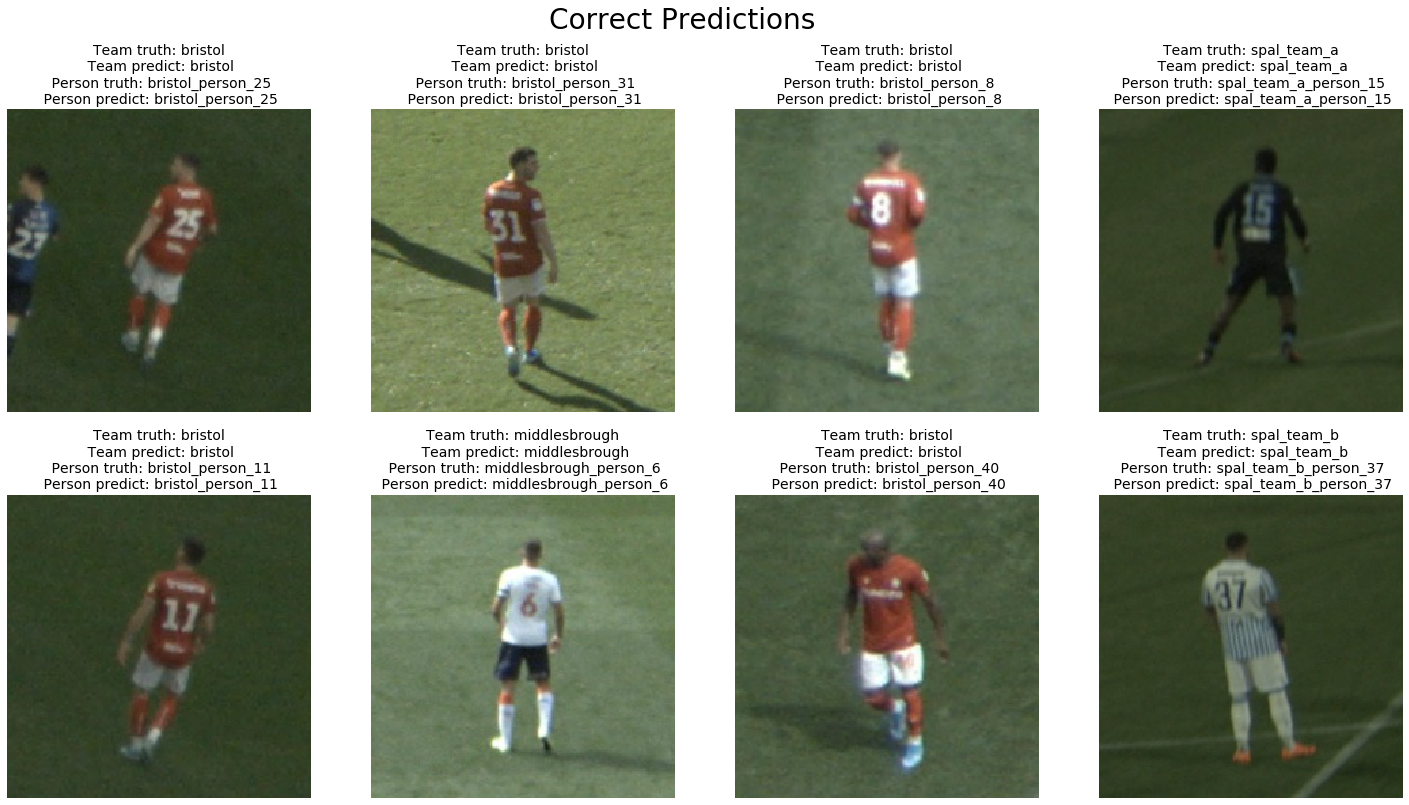

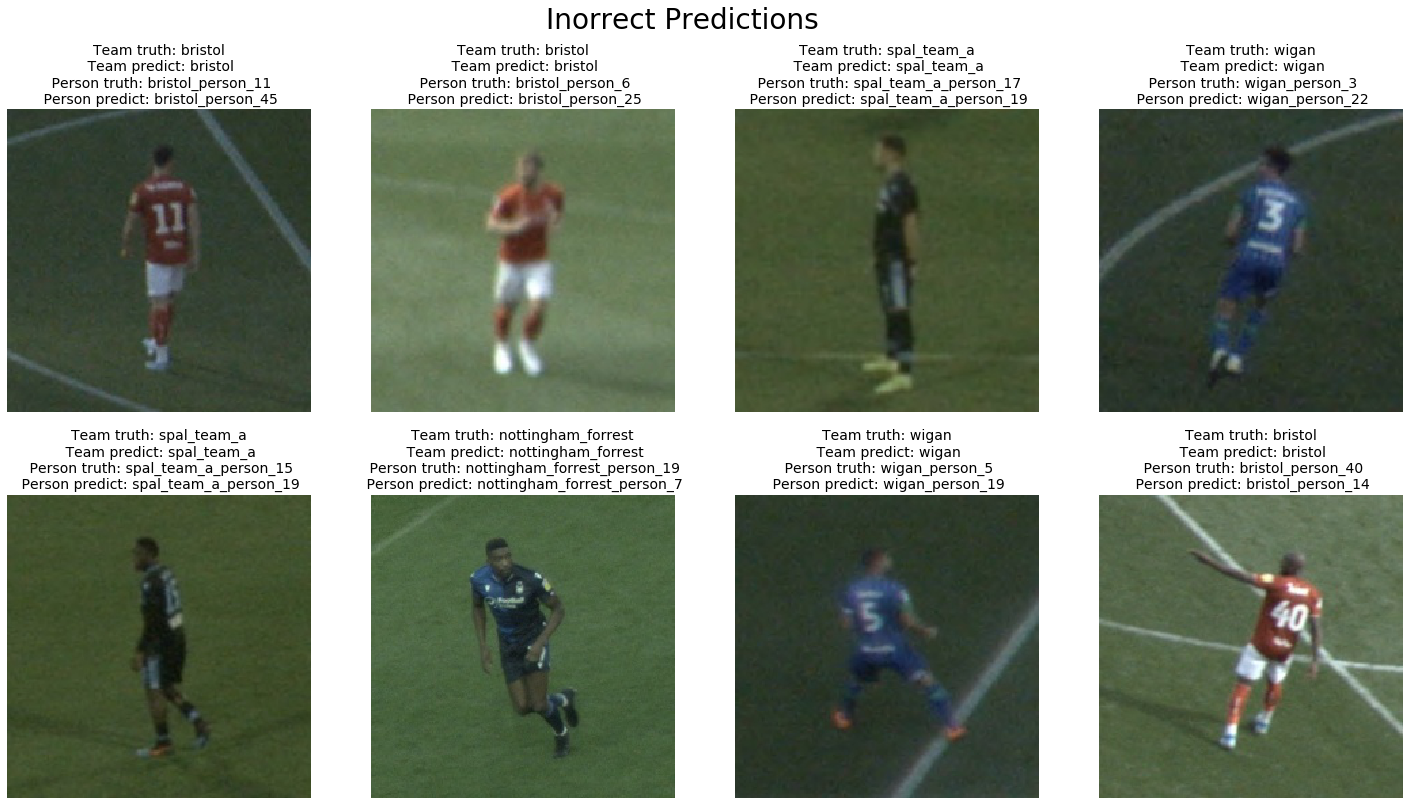

In [26]:
# plot some correct predictions
plot_tiles(idx_to_plot_correct,nrows=2,ncols=4,suptitle='Correct Predictions')
# plot some incorrect predictions
plot_tiles(idx_to_plot_incorrect,nrows=2,ncols=4,suptitle='Inorrect Predictions')

It is noticable that most of the correct predictions shown here are facing away from the camera, perhaps suggesting that the model is using the shirt number to predict the player.

In contrast, many of the incorrect predictions do not have a clear view of the shirt number, and therefore may be causing the model issues in identifying the player. The prediction of bristol_player_14 instead of bristol_player_40 may support this theory with the model identifying the "4" but being overfitted to bristol_player_14. When bristol_player_40 is facing the camera, it does appear to correctly predict it.

Another issue is the model overfitting to the training data and not generalising well to data it hasn't seen. There is a small improvement from this model, which has an accuracy of around 59% for the test set, to the person only model which had an accuracy of around 53%. Therefore including the team as a second class has helped to identify players. However, this is still significantly below the training set accuracy and therefore the model would need to be developed further to prevent overfitting.

Aside from optimisation of the model architecture and hyperparameters, the model could be developed further by implementing a region-based CNN to compliment the player tile CNN here. The tile could be split into different CNNs to predict body parts and then joined together with the complete tile CNN to predict the player. This could help distinguish players by their body features rather than the shirt & number they are wearing. In all incorrect cases above, the team is correctly identified but the player is not. By splitting the image up into these body parts, the model would no longer rely as heavily on the team and could distinguish players better.

# SAVE MODEL

In [29]:
# SAVING MODEL
# get example input from test set
example_im = torch.zeros(1, 3, 224, 224)

# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
traced_script_module = torch.jit.trace(model, example_im)

# test output
output = traced_script_module(example_im)
# print(output)

# save model
traced_script_module.save("team_and_person_model.pt")